In [35]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path
from scipy.interpolate import RBFInterpolator

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation, my_discrete_cmap
from flowrec.utils.py_helper import slice_from_tuple
from flowrec.utils.system import set_gpu
set_gpu(0,0.5)

In [2]:
result_dir = Path('../local_results/2dtriangle/repeat_noisy/noisy_random')
if not result_dir.exists():
    raise ValueError

In [23]:
def get_summary_one_case(folder):
    with h5py.File(Path(result_dir,folder,'summary.h5')) as hf:
        l_train = np.array(hf.get('runs_loss_train'))
        l_val = np.array(hf.get('runs_loss_val'))
        idx = np.argmin(np.sum(l_train[:,1:],axis=-1))
        best_run = np.array(hf.get('runs_name')).astype('unicode')[idx]
    best_run_path = Path(result_dir,folder,best_run)
    
    lmean = np.array([np.mean(l_train[:,0]), np.mean(l_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd = np.array([np.std(l_train[:,0]), np.std(l_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    lpmean = np.array([
        np.mean(np.sum(l_train[:,1:3],axis=1)),
        np.mean(np.sum(l_val[:,1:3],axis=1))
    ])
    lpstd = np.array([
        np.std(np.sum(l_train[:,1:3],axis=1)),
        np.std(np.sum(l_val[:,1:3],axis=1))
    ])
 
    return lmean, lstd, lpmean, lpstd, best_run_path

## Load summary file

In [24]:
lmean_snr20_classic, lstd_snr20_classic, lpmean_snr20_classic, lpstd_snr20_classic, run_snr20_classic= get_summary_one_case('snr20_classic')
lmean_snr20_3, lstd_snr20_3, lpmean_snr20_3, lpstd_snr20_3, run_snr20_3 = get_summary_one_case('snr20_3')
lmean_snr20_mean3, lstd_snr20_mean3, lpmean_snr20_mean3, lpstd_snr20_mean3, run_snr20_mean3 = get_summary_one_case('snr20_mean3')

lmean_snr10_classic, lstd_snr10_classic, lpmean_snr10_classic, lpstd_snr10_classic, run_snr10_classic = get_summary_one_case('snr10_classic')
lmean_snr10_3, lstd_snr10_3, lpmean_snr10_3, lpstd_snr10_3, run_snr10_3 = get_summary_one_case('snr10_3')
lmean_snr10_mean3, lstd_snr10_mean3, lpmean_snr10_mean3, lpstd_snr10_mean3, run_snr10_mean3 = get_summary_one_case('snr10_mean3')

lmean_snr5_classic, lstd_snr5_classic, lpmean_snr5_classic, lpstd_snr5_classic, run_snr5_classic = get_summary_one_case('snr5_classic')
lmean_snr5_3, lstd_snr5_3, lpmean_snr5_3, lpstd_snr5_3, run_snr5_3 = get_summary_one_case('snr5_3')
lmean_snr5_mean3, lstd_snr5_mean3, lpmean_snr5_mean3, lpstd_snr5_mean3, run_snr5_mean3 = get_summary_one_case('snr5_mean3')


Compare relative error

In [26]:
l_mean_classic = []
l_mean_classic.append(lmean_snr20_classic)
l_mean_classic.append(lmean_snr10_classic)
l_mean_classic.append(lmean_snr5_classic)
l_mean_classic = np.array(l_mean_classic)*100
l_std_classic = []
l_std_classic.append(lstd_snr20_classic)
l_std_classic.append(lstd_snr10_classic)
l_std_classic.append(lstd_snr5_classic)
l_std_classic = np.array(l_std_classic)*100

l_mean_3 = []
l_mean_3.append(lmean_snr20_3)
l_mean_3.append(lmean_snr10_3)
l_mean_3.append(lmean_snr5_3)
l_mean_3 = np.array(l_mean_3)*100
l_std_3 = []
l_std_3.append(lstd_snr20_3)
l_std_3.append(lstd_snr10_3)
l_std_3.append(lstd_snr5_3)
l_std_3 = np.array(l_std_3)*100

l_mean_mean3 = []
l_mean_mean3.append(lmean_snr20_mean3)
l_mean_mean3.append(lmean_snr10_mean3)
l_mean_mean3.append(lmean_snr5_mean3)
l_mean_mean3 = np.array(l_mean_mean3)*100
l_std_mean3 = []
l_std_mean3.append(lstd_snr20_mean3)
l_std_mean3.append(lstd_snr10_mean3)
l_std_mean3.append(lstd_snr5_mean3)
l_std_mean3 = np.array(l_std_mean3)*100

In [27]:
# l_mean_classic - rows: 20,10,5 snr. columns: training,testing

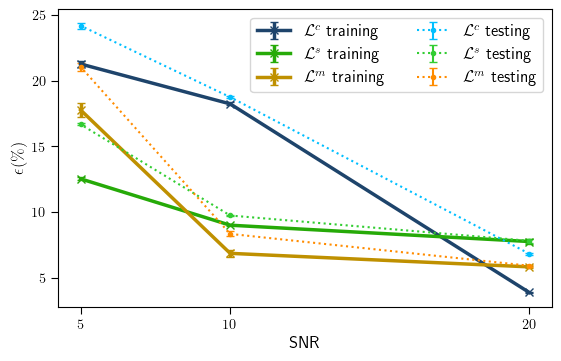

In [28]:
snr = [20,10,5]
plt.figure(figsize=(5.5,3.5))
ax = plt.subplot(111)

ax.errorbar(snr,l_mean_classic[:,0],yerr=l_std_classic[:,0],label='$\mathcal{L}^c$ training',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
ax.errorbar(snr,l_mean_3[:,0],yerr=l_std_3[:,0],label='$\mathcal{L}^s$ training',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
ax.errorbar(snr,l_mean_mean3[:,0],yerr=l_std_mean3[:,0],label='$\mathcal{L}^m$ training',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

ax.errorbar(snr,l_mean_classic[:,1],yerr=l_std_classic[:,1],label='$\mathcal{L}^c$ testing',marker='.',color='deepskyblue',linestyle=':')
ax.errorbar(snr,l_mean_3[:,1],yerr=l_std_3[:,1],label='$\mathcal{L}^s$ testing',marker='.',linestyle=':',color='limegreen')
ax.errorbar(snr,l_mean_mean3[:,1],yerr=l_std_mean3[:,1],label='$\mathcal{L}^m$ testing',marker='.',linestyle=':',color='darkorange',)

ax.legend(ncol=2)
ax.set_ylabel('$\epsilon (\%)$')
ax.set_xticks([5,10,20])
ax.set_xlabel('SNR')
# ax.set_yscale('log')
# plt.ylim([0,70])
# plt.savefig('./figs/noisy_compare_lossfn')
plt.show()

Compare physics loss

In [29]:
lp_mean_classic = []
lp_mean_classic.append(lpmean_snr20_classic)
lp_mean_classic.append(lpmean_snr10_classic)
lp_mean_classic.append(lpmean_snr5_classic)
lp_mean_classic = np.array(lp_mean_classic)
lp_std_classic = []
lp_std_classic.append(lpstd_snr20_classic)
lp_std_classic.append(lpstd_snr10_classic)
lp_std_classic.append(lpstd_snr5_classic)
lp_std_classic = np.array(lp_std_classic)

lp_mean_3 = []
lp_mean_3.append(lpmean_snr20_3)
lp_mean_3.append(lpmean_snr10_3)
lp_mean_3.append(lpmean_snr5_3)
lp_mean_3 = np.array(lp_mean_3)
lp_std_3 = []
lp_std_3.append(lpstd_snr20_3)
lp_std_3.append(lpstd_snr10_3)
lp_std_3.append(lpstd_snr5_3)
lp_std_3 = np.array(lp_std_3)

lp_mean_mean3 = []
lp_mean_mean3.append(lpmean_snr20_mean3)
lp_mean_mean3.append(lpmean_snr10_mean3)
lp_mean_mean3.append(lpmean_snr5_mean3)
lp_mean_mean3 = np.array(lp_mean_mean3)
lp_std_mean3 = []
lp_std_mean3.append(lpstd_snr20_mean3)
lp_std_mean3.append(lpstd_snr10_mean3)
lp_std_mean3.append(lpstd_snr5_mean3)
lp_std_mean3 = np.array(lp_std_mean3)

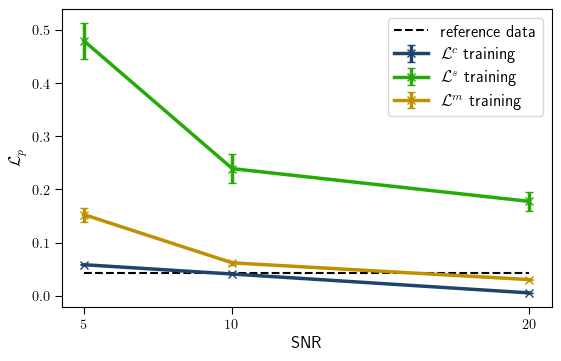

In [30]:
snr = [20,10,5]
plt.figure(figsize=(5.5,3.5))
ax = plt.subplot(111)

# training set
ax.errorbar(snr,lp_mean_classic[:,0],yerr=lp_std_classic[:,0],label='$\mathcal{L}^c$ training',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
ax.errorbar(snr,lp_mean_3[:,0],yerr=lp_std_3[:,0],label='$\mathcal{L}^s$ training',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
ax.errorbar(snr,lp_mean_mean3[:,0],yerr=lp_std_mean3[:,0],label='$\mathcal{L}^m$ training',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

#validation set
# ax.errorbar(snr,lp_mean_classic[:,1],yerr=lp_std_classic[:,1],label='$\mathcal{L}^c$ testing',marker='.',color='deepskyblue',linestyle=':')
# ax.errorbar(snr,lp_mean_3[:,1],yerr=lp_std_3[:,1],label='$\mathcal{L}^s$ testing',marker='.',linestyle=':',color='darkorange')
# ax.errorbar(snr,lp_mean_mean3[:,1],yerr=lp_std_mean3[:,1],label='$\mathcal{L}^m$ testing',marker='.',linestyle=':',color='limegreen',)

ax.hlines(0.043, xmin=5,xmax=20, colors=['k'], linestyles='dashed',label='reference data')
ax.legend(ncol=1)
ax.set_ylabel('$\mathcal{L}_p$')
ax.set_xticks([5,10,20])
ax.set_xlabel('SNR')
# ax.set_yscale('log')
# plt.ylim([0,70])
# plt.savefig('./figs/noisy_compare_lossfn_physics')
plt.show()

## Compare flowfields

In [38]:
def interpolate(u,pb,case_observe,datacfg):

    take_observation, insert_observation = case_observe(datacfg, example_pred_snapshot=u[0,...],example_pin_snapshot=pb[0,...])
    observed = take_observation(u)
    temp_observed = np.empty_like(u)
    temp_observed.fill(np.nan) #this is noisy
    temp_observed = insert_observation(jnp.asarray(temp_observed),jnp.asarray(observed)) # observed_test is noisy if

    # get sensor coordinates
    sensors_empty = np.empty_like(u[[0],...])
    sensors_empty.fill(np.nan)

    grid_x,grid_y = np.mgrid[0:u[...,0].shape[1], 0:u[...,0].shape[2]]

    gridx1 = np.repeat(grid_x[None,:,:,None],3,axis=3)
    gridy1 = np.repeat(grid_y[None,:,:,None],3,axis=3)

    idx_x = take_observation(gridx1)
    idx_y = take_observation(gridy1)

    idx_x = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_x))[0,...]
    sensors_loc_x = []
    for i in range(idx_x.shape[-1]):
        sensors_loc_x.append(idx_x[...,i][~np.isnan(idx_x[...,i])])

    idx_y = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_y))[0,...]
    sensors_loc_y = []
    for i in range(idx_y.shape[-1]):
        sensors_loc_y.append(idx_y[...,i][~np.isnan(idx_y[...,i])])


    compare_interp = list([])
    nt = u.shape[0]
    _locs = np.stack((grid_x.flatten(),grid_y.flatten()),axis=-1)

    for i in range(3):
        sensors_loc = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=-1)
        for j in range(nt):
            temp_measurement = temp_observed[j,...,i][~np.isnan(temp_observed[j,...,i])]
            # print(sensors_loc.shape, temp_measurement.shape)
            rbf = RBFInterpolator(sensors_loc,temp_measurement.flatten(),kernel='thin_plate_spline')
            _interp = rbf(_locs).reshape(grid_x.shape)
            compare_interp.append(_interp)
    compare_interp = np.array(compare_interp)
    compare_interp = np.stack((compare_interp[:nt,...],compare_interp[nt:2*nt,...],compare_interp[2*nt:3*nt,...]),axis=-1)

    return compare_interp, temp_observed

In [41]:
def get_single_case_predictions(results_dir):
    with open(Path(results_dir,'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
    cfg.data_config.update({'data_dir':'.'+cfg.data_config.data_dir})
    x_base = 132
    triangle_base_coords = [49,80]
    (ux,uy,pp) = simulation.read_data_2dtriangle(cfg.data_config.data_dir,x_base)
    x = np.stack([ux,uy,pp],axis=0)
    # remove parts where uz is not zero
    s = slice_from_tuple(cfg.data_config.slice_to_keep)
    x = x[s]

    # information about the grid
    datainfo = data_utils.DataMetadata(
        re = cfg.data_config.re,
        discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
        axis_index=[0,1,2],
        problem_2d=True
    ).to_named_tuple()

    rng = np.random.default_rng(cfg.data_config.randseed)
    if cfg.data_config.snr:
        [x_train,x_val,x_test], _ = data_utils.data_partition(x,1,cfg.data_config.train_test_split,REMOVE_MEAN=cfg.data_config.remove_mean,randseed=cfg.data_config.randseed,SHUFFLE=cfg.data_config.shuffle) # Do not shuffle, do not remove mean for training with physics informed loss
        [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
        [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
        [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))
        u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
        u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
        u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)

        
        std_data = np.std(x,axis=(1,2,3),ddof=1)
        std_n = data_utils.get_whitenoise_std(cfg.data_config.snr,std_data)
        noise_ux = rng.normal(scale=std_n[0],size=x[0,...].shape)
        noise_uy = rng.normal(scale=std_n[1],size=x[1,...].shape)
        noise_pp = rng.normal(scale=std_n[2],size=x[2,...].shape)
        noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
        x = x + noise


    [x_train_n,x_val_n,x_test_n], _ = data_utils.data_partition(
        x,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        randseed=cfg.data_config.randseed,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss
    [ux_train_n,uy_train_n,pp_train_n] = np.squeeze(np.split(x_train_n,3,axis=0))
    [ux_val_n,uy_val_n,pp_val_n] = np.squeeze(np.split(x_val_n,3,axis=0))
    [ux_test_n,uy_test_n,pp_test_n] = np.squeeze(np.split(x_test_n,3,axis=0))
    u_train_n = np.stack((ux_train_n,uy_train_n,pp_train_n),axis=-1)
    u_val_n = np.stack((ux_val_n,uy_val_n,pp_val_n),axis=-1)
    u_test_n = np.stack((ux_test_n,uy_test_n,pp_test_n),axis=-1)

    pb_train = simulation.take_measurement_base(pp_train_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[0],-1))
    pb_val = simulation.take_measurement_base(pp_val_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[1],-1))
    pb_test = simulation.take_measurement_base(pp_test_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[2],-1))

    take_observation, insert_observation = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_train_n[0,...],example_pin_snapshot=pb_train[0,...])
    observed_train, train_minmax = take_observation(u_train_n,init=True)
    observed_val, val_minmax = take_observation(u_val_n,init=True)
    observed_test, test_minmax = take_observation(u_test_n,init=True)
    
    state = state_utils.restore_trainingstate(results_dir,'state')
    _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
    mdl = make_model(cfg.model_config)

    if cfg.data_config.normalise:
        [pb_train, pb_val, pb_test], _ = data_utils.normalise(pb_train, pb_val, pb_test, range=[train_minmax[-1],val_minmax[-1],test_minmax[-1]])

    rng = jax.random.PRNGKey(10)

    pb_train_batch = np.array_split(pb_train,2,0)
    pred_train = []
    for inn in pb_train_batch:
        pred_train.append(mdl.apply(state.params,rng,inn,TRAINING=False))
    pred_train = np.concatenate(pred_train)
    pred_test = mdl.apply(state.params,rng,pb_test,TRAINING=False)
    if cfg.data_config.normalise:
        pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
        pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)

    u_interp, observed = interpolate(u_train_n, pb_train, cfg.case.observe, cfg.data_config)
    
    print(f'Finished {results_dir}')

    return (u_train ,u_train_n, u_interp, pred_train), datainfo, observed

Get results

In [42]:
results_20, datainfo, observed_20 = get_single_case_predictions(run_snr20_classic)
results_20 = list[results_20]
for run in [run_snr20_3, run_snr20_mean3]:
    result, _, _ = get_single_case_predictions(run)
    results_20.append(result[-1])
print('1')

results_10, datainfo, observed_10 = get_single_case_predictions(run_snr10_classic)
results_10 = list[results_10]
for run in [run_snr10_3, run_snr10_mean3]:
    result, _, _ = get_single_case_predictions(run)
    results_10.append(result[-1])
print('1')

results_5, datainfo, observed_5 = get_single_case_predictions(run_snr5_classic)
results_5 = list[results_5]
for run in [run_snr5_3, run_snr5_mean3]:
    result, _, _ = get_single_case_predictions(run)
    results_5.append(result[-1])
print('1')


KeyboardInterrupt: 

In [ ]:
len(results_20)